In [38]:
import pandas as pd
import numpy as np

In [39]:
# title budget genres country main_charactor director vote_average vote_count
df = pd.concat([pd.read_csv('data/movie_genres_data.csv'), pd.read_csv('data/movie_data_ID.csv')], axis=1)

In [40]:
# heatmap의 상관관계 있는 장르만 사용해보자
# 액션, 모험, 판타지 sf, 드라마 공포, 스릴러, 미스터리, 로맨스
df = df.drop(['가족','애니메이션','코미디', '음악', '역사','TV 영화','전쟁','다큐멘터리','서부', '범죄'], axis=1)

In [41]:
# 로지스틱 회귀 모델(sigmoid) : weight초기화, dropout, ReLU, batch nomalization
# 결과 : 흥행성공, 흥행 실패, 전체영화 의 평균 정확도
# 1. 데이터셋 준비하기
df.drop(['genres', 'country', 'vote_score', 'vote_count'], axis=1, inplace=True)
df.vote_weight = df.vote_weight.apply(lambda x: 1 if x >= 11 else 0)

In [42]:
print(df.budget.max())
print(df.charactor.max())
print(df.director.max())

380000000
3646905
3646897


In [26]:
df.budget = df.budget / df.budget.max()
df.charactor = df.charactor / df.charactor.max()
df.director = df.director / df.director.max()

In [28]:
df.to_csv('data/movie_data_ML_op.csv', index=False)

In [29]:
df.drop(['title'], axis=1, inplace=True)
df.drop(['budget'], axis=1, inplace=True)

In [30]:
df.head(1)

,액션,모험,판타지,SF,드라마,공포,스릴러,미스터리,로맨스,charactor,director,vote_weight
0,1,1,1,0,0,0,0,0,0,0.001068,0.015337,0


In [31]:
X = np.array(df)

In [32]:
# y_train : 흥행했는지(1) 안했는지(0)
from sklearn.model_selection import train_test_split
y = X[:, 11:]
X = X[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_val = X_test[:513]
y_val = y_test[:513]

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4102, 11)
(4102, 1)
(513, 11)
(513, 1)
(1026, 11)
(1026, 1)


- 모델 구성 및 분석

In [34]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams.update({'text.color': "black",
                    'axes.labelcolor': "white",
                     'xtick.color': "white",
                     'ytick.color': "white"
                     })

Epoch 1/50
129/129 [==============================] - 1s 3ms/step - loss: 0.7862 - accuracy: 0.5324 - val_loss: 0.7555 - val_accuracy: 0.5205
Epoch 2/50
129/129 [==============================] - 0s 3ms/step - loss: 0.7220 - accuracy: 0.5651 - val_loss: 0.7144 - val_accuracy: 0.5439
Epoch 3/50
129/129 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5773 - val_loss: 0.6974 - val_accuracy: 0.5556
Epoch 4/50
129/129 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5846 - val_loss: 0.6886 - val_accuracy: 0.5595
Epoch 5/50
129/129 [==============================] - 0s 2ms/step - loss: 0.6765 - accuracy: 0.5882 - val_loss: 0.6862 - val_accuracy: 0.5614
Epoch 6/50
129/129 [==============================] - 0s 2ms/step - loss: 0.6735 - accuracy: 0.5836 - val_loss: 0.6814 - val_accuracy: 0.5595
Epoch 7/50
129/129 [==============================] - 0s 2ms/step - loss: 0.6705 - accuracy: 0.5990 - val_loss: 0.6808 - val_accuracy: 0.5634
Epoch 

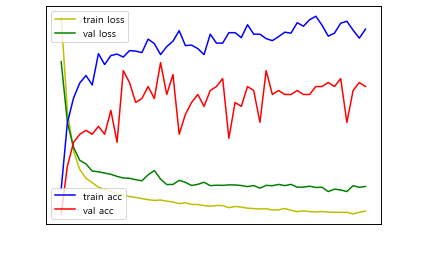

In [35]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
import tensorflow as tf
model = Sequential()
# 1. 과적합 : train acc 85%, test acc 65% => Node수와 Hidden Layer수를 줄여야함
#model.add(Dense(64, activation='relu', input_dim=22))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))

# 2. Dense의 한계치 : test acc 68% => 다른 모델을 사용해야함, L2 Regularization : test acc 69%
#model.add(Dense(32, activation='relu', input_dim=22))
#model.add(Dense(1, activation='sigmoid'))
tf.keras.regularizers.L2(
    l2=0.01
)
# Dropout 68.5%
model.add(Dense(32, activation='relu', input_dim=11))
model.add(Dense(10, kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train, epochs=50, batch_size=32,
                 validation_data=(X_val, y_val))

loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print('손실 :', loss_and_metrics[0])
print('정확도 :', loss_and_metrics[1] * 100, '%')
print("-" * 20)

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')

loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [36]:
yhat = model.predict(X_test)
for i in range(10):
    print(1 if yhat[i] > 0.5 else 0, end=" ")
print()
for i in y_test[:10]:
    print(int(*i), end=" ")

33/33 [==============================] - 0s 2ms/step
0 1 0 0 1 0 1 0 1 0 
1 1 0 1 1 0 1 1 0 0 

In [37]:
model.save('model/Dense_Dropout_nobudget.h5')